<a href="https://colab.research.google.com/github/nickplas/Intro_to_ML_24-25/blob/main/challenges/challenge-one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge 1: The banknote-authentication data set problem

We will perform a nearly realistic analysis of the data set bank note authentication that can be downloaded from https://archive.ics.uci.edu/dataset/267/banknote+authentication

## Data set description

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.
These features are:
1. variance of Wavelet Transformed image (continuous) 
2. skewness of Wavelet Transformed image (continuous) 
3. curtosis of Wavelet Transformed image (continuous) 
4. entropy of image (continuous) 
5. class (integer)

## Task description
We have a binary classification problem. The assignment can be divided in several parts:
    
    1. Load the data and pretreatment.
    2. Data exploring by Unsupervised Learning techniques.
    3. Construction of several models of Supervised Learning.

### 1. Data pretreatment

Load the data and look at it: It is needed some kind of scaling? Why? Are the data points sorted in the original data set? Can it generate problems? How can this be solved?

In [47]:
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy as cp
import itertools as it
import pandas as pd
import numpy as np
import seaborn as sns
import numpy.linalg as LA
from sklearn import preprocessing, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.naive_bayes import  GaussianNB, ComplementNB, BernoulliNB
from scipy.spatial.distance import euclidean, minkowski
from tqdm import tqdm

In [48]:
#importo il dataset e divido label e feature in 2 diversi dataframe
banknote_authentication = fetch_ucirepo(id=267)  
X = banknote_authentication.data.features 
y = banknote_authentication.data.targets 
#mi prendo i nomi delle feature
feature = X.columns

In [49]:
data = X.iloc[:,:]
data['class'] = y
print(data.head())
print(X.shape,data.shape)

   variance  skewness  curtosis  entropy  class
0   3.62160    8.6661   -2.8073 -0.44699      0
1   4.54590    8.1674   -2.4586 -1.46210      0
2   3.86600   -2.6383    1.9242  0.10645      0
3   3.45660    9.5228   -4.0112 -3.59440      0
4   0.32924   -4.4552    4.5718 -0.98880      0
(1372, 4) (1372, 5)


In [50]:
data = data.sample(frac=1,random_state=4).reset_index(drop=True) 
data.head()


,variance,skewness,curtosis,entropy,class
0,0.64295,7.1018,0.34930,-0.41337,0
1,2.30660,3.5364,0.57551,0.41938,0
2,-3.57410,3.9440,-0.07912,-2.12030,1
3,3.95290,-2.3548,2.37920,0.48274,0
4,0.74307,11.1700,-1.38240,-4.07280,0


In [51]:
X = data.iloc[:,:4]
y = data.iloc[:,4]
print(X.head())
print(y.head())

   variance  skewness  curtosis  entropy
0   0.64295    7.1018   0.34930 -0.41337
1   2.30660    3.5364   0.57551  0.41938
2  -3.57410    3.9440  -0.07912 -2.12030
3   3.95290   -2.3548   2.37920  0.48274
4   0.74307   11.1700  -1.38240 -4.07280
0    0
1    0
2    1
3    0
4    0
Name: class, dtype: int64


In [53]:
#scalo i dati per l'unsupervise così da rendere i grafici piu leggibili
scaler = preprocessing.StandardScaler().fit(X)
x_uns = scaler.transform(X)


In [54]:
#prendo le classi della var label per averle come array e non pd dataframe
y_enc = y.values
y_enc = y_enc.reshape(1,-1)
y_enc = y_enc[0]
print(y_enc)

[0 0 1 ... 0 0 1]


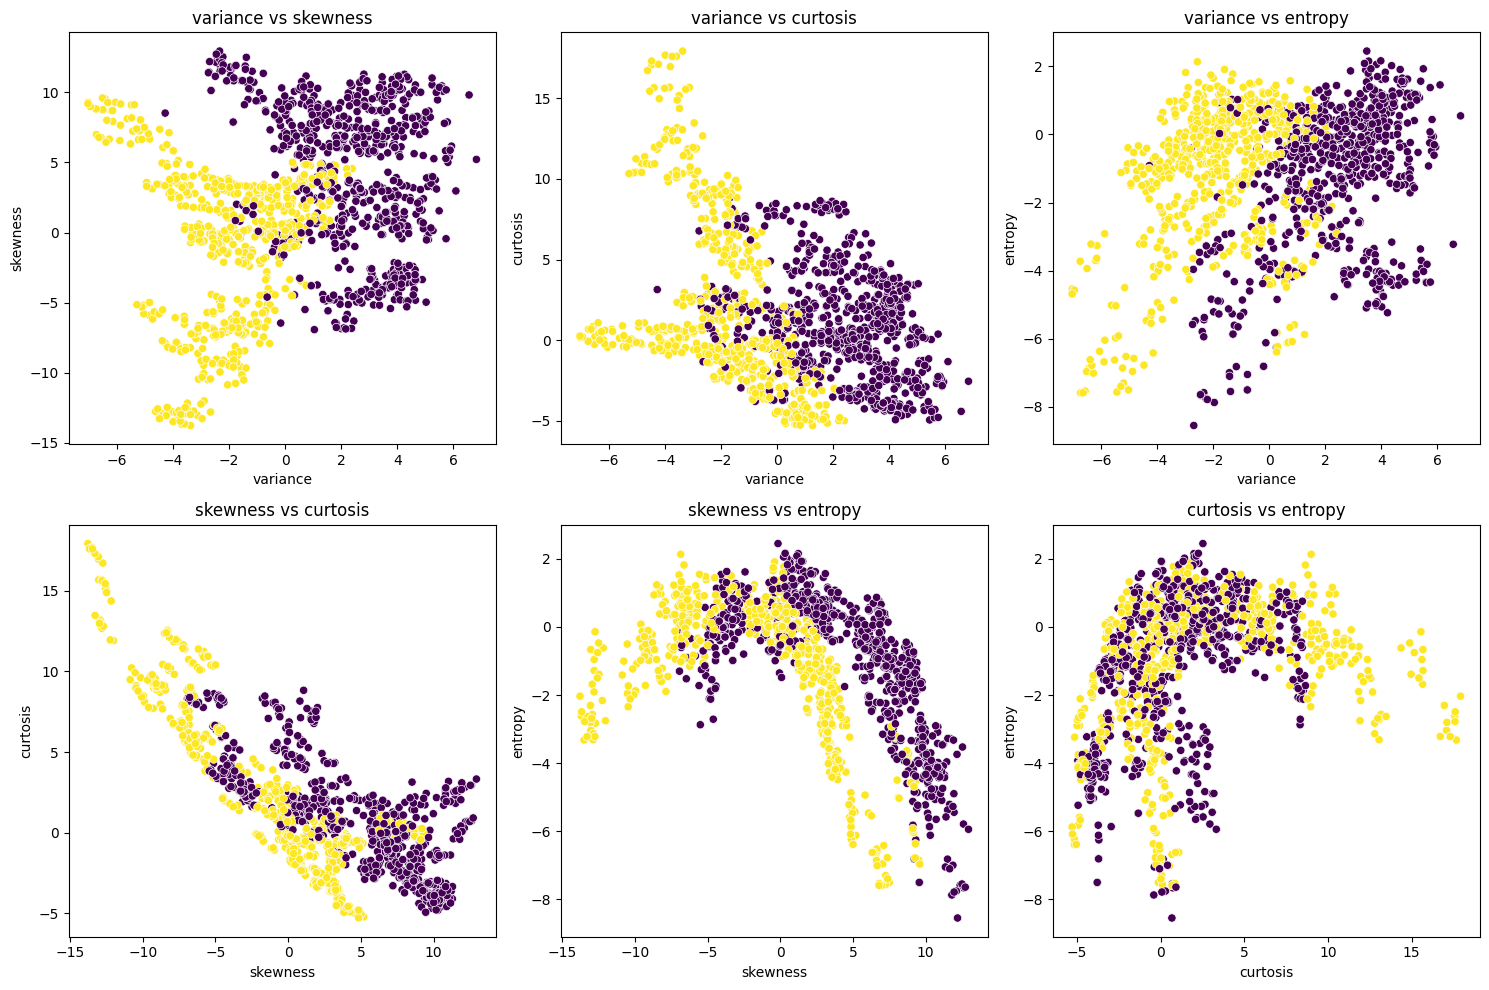

In [55]:
combinazioni = [(feature[0],feature[1]),
                (feature[0],feature[2]),
                (feature[0],feature[3]),
                (feature[1],feature[2]),
                (feature[1],feature[3]),
                (feature[2],feature[3])
                ]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, (col1, col2) in enumerate(combinazioni):
    sns.scatterplot(data=X, x=col1, y=col2, ax=axes[i], c=y_enc)
    axes[i].set_title(f'{col1} vs {col2}')
plt.tight_layout()
plt.show()


a primo impatto sembra difficile separare i dati in 2 cluster separati, soprattutto in alcune zone di conflitto 

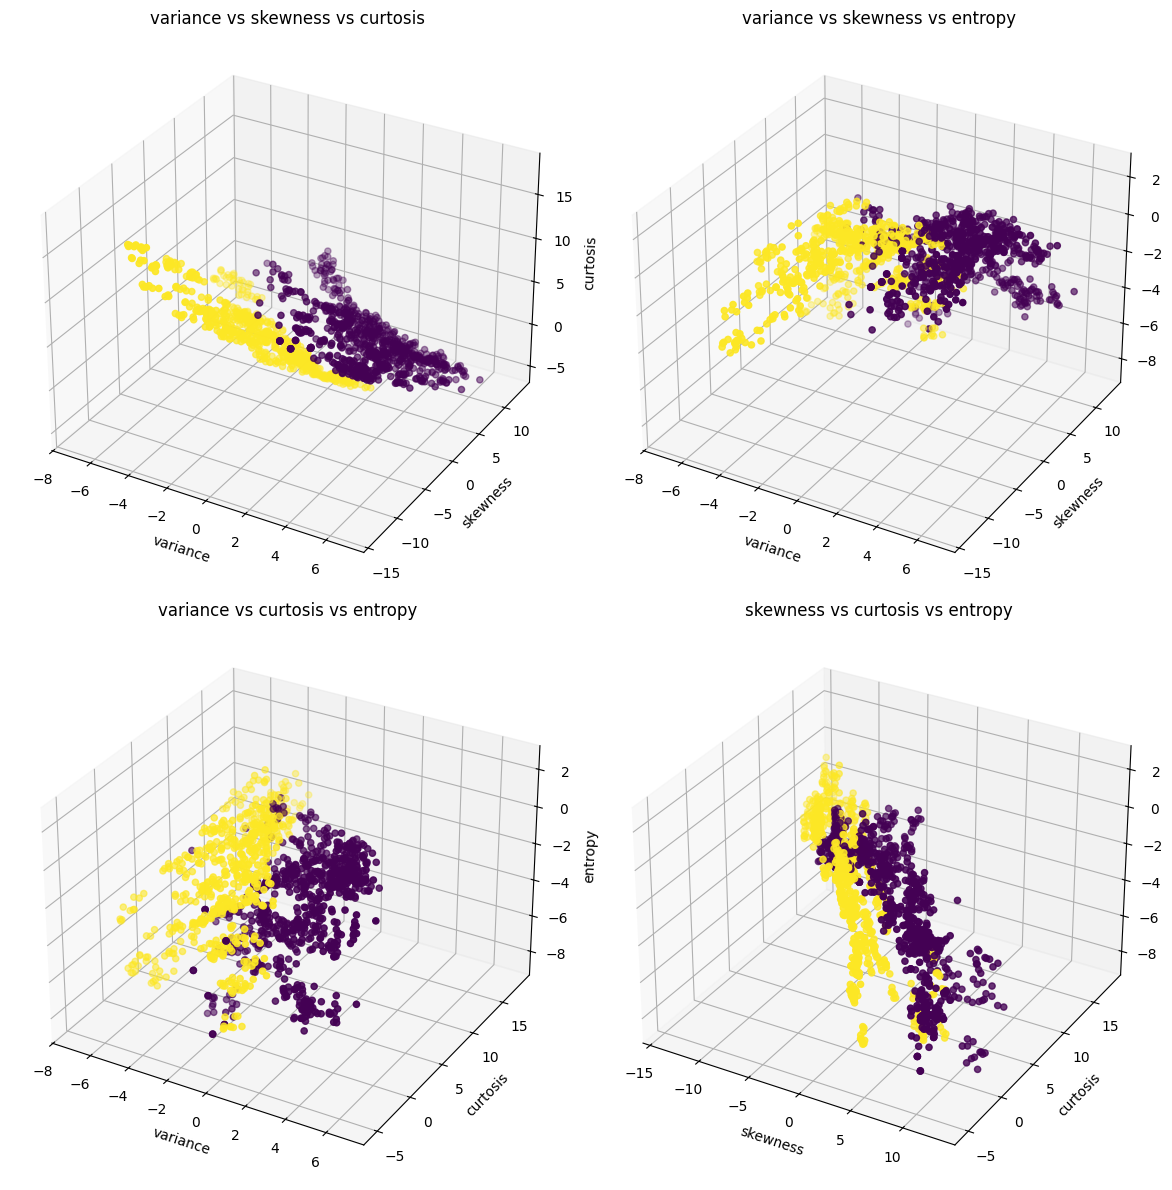

In [56]:
combinazioni_3d = [
    (feature[0], feature[1], feature[2]),
    (feature[0], feature[1], feature[3]),
    (feature[0], feature[2], feature[3]),
    (feature[1], feature[2], feature[3])
]
fig = plt.figure(figsize=(12, 12))
for i, (col1, col2, col3) in enumerate(combinazioni_3d):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')  # 2x2 grid per 4 grafici
    ax.scatter(X[col1], X[col2], X[col3], c=y_enc)  # Creazione del grafico 3D
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.set_zlabel(col3)
    ax.set_title(f'{col1} vs {col2} vs {col3}')

plt.tight_layout()
plt.show()


a dimensione superiore sembra invece più plausibile trovare una separazione tra i 2 cluster

### 2. Unsupervised Learning

Use PCA and plot the two first components colouring according with the class. Are the classes linearly separable in this projection? What happens when I applied k-means with two classes in this space? And if I use all the coordinates? Try also t-SNE for projection and DBSCAN for the clustering and comment on the results.

Text(0.5, 1.0, '2D PCA Visualization')

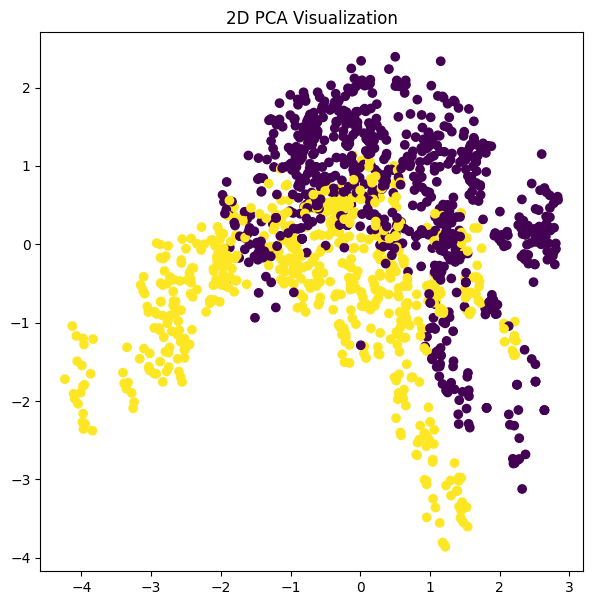

In [57]:
#creo il modello
pca = PCA()
pca.fit(x_uns)
projection = pca.transform(x_uns)

#faccio il plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(projection[:, 0], projection[:, 1], c=y_enc)
ax.set_title('2D PCA Visualization')

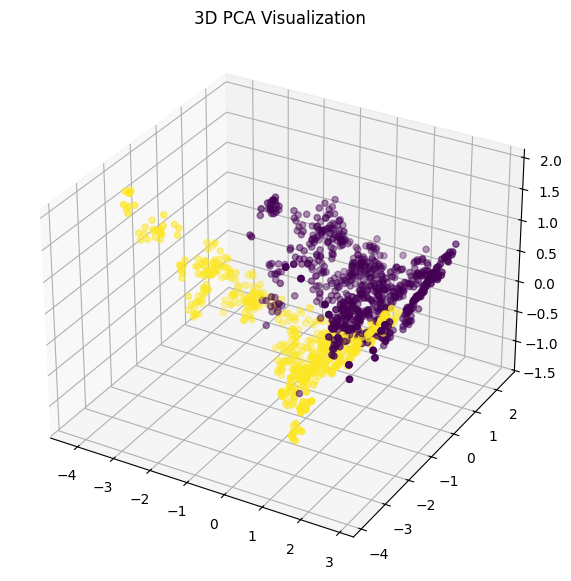

In [58]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')
ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], c=y)
ax.set_title('3D PCA Visualization')
plt.show()

le 2 classi non sembrano facilmente separabili linearmente


Text(0.5, 1.0, 'kernell kmeans')

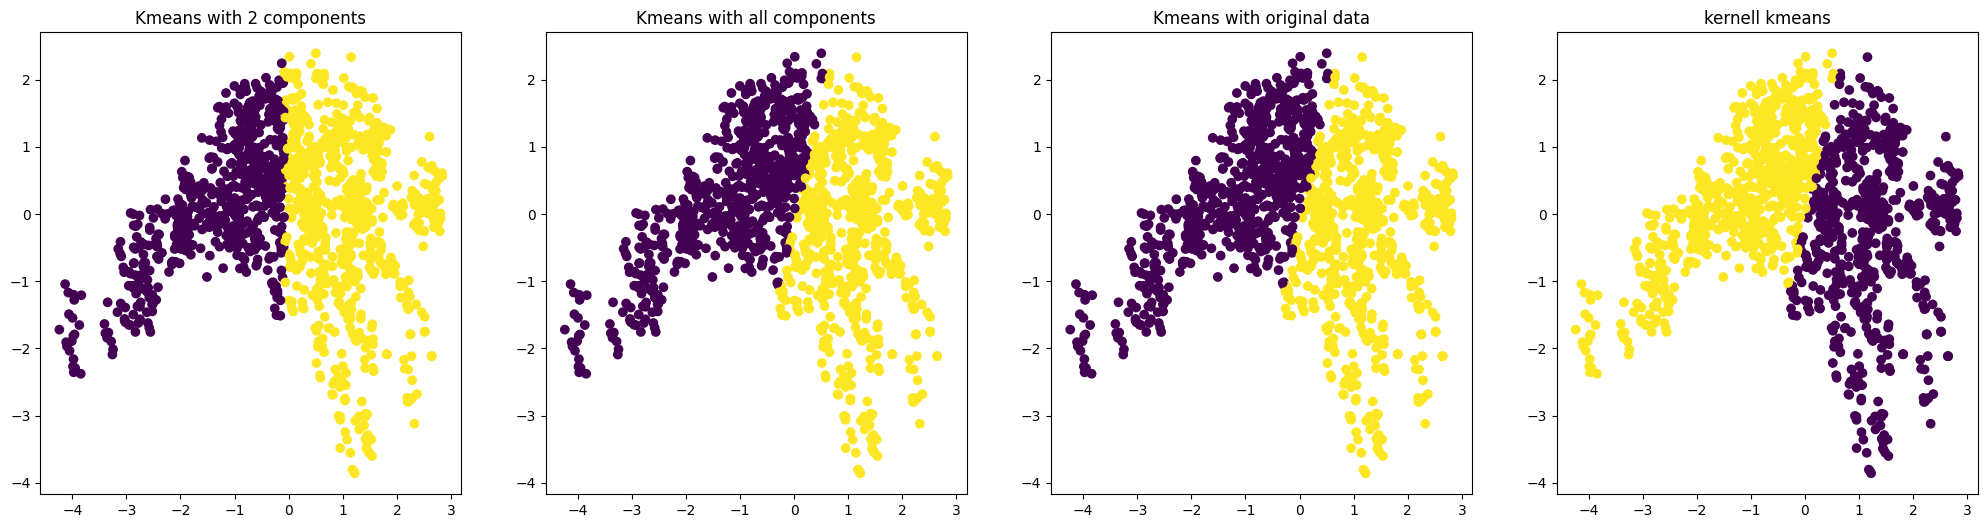

In [59]:
kmeans_2 = KMeans(n_clusters=2, random_state=0, n_init=20).fit(projection[:,:1])
kmeans_all = KMeans(n_clusters=2, random_state=0, n_init=20).fit(projection)
kmeans = KMeans(n_clusters=2, random_state=0, n_init=20).fit(x_uns)
kmeans_pp = KMeans(n_clusters=2, init='k-means++', n_init=20).fit(x_uns)
fig, ax = plt.subplots(1,4,figsize=(25, 6))
ax[0].scatter(projection[:, 0], projection[:, 1], c=kmeans_2.labels_)
ax[0].set_title('Kmeans with 2 components')
ax[1].scatter(projection[:,0],projection[:,1], c=kmeans_all.labels_)
ax[1].set_title('Kmeans with all components')
ax[2].scatter(projection[:,0],projection[:,1], c=kmeans.labels_)
ax[2].set_title('Kmeans with original data')
ax[3].scatter(projection[:,0],projection[:,1], c=kmeans_pp.labels_)
ax[3].set_title('kernell kmeans')


possiamo vedere che i 2 cluster non vengono per niente separati in manirea corretta. suppongo questo sia perchè i cluster sono concavi

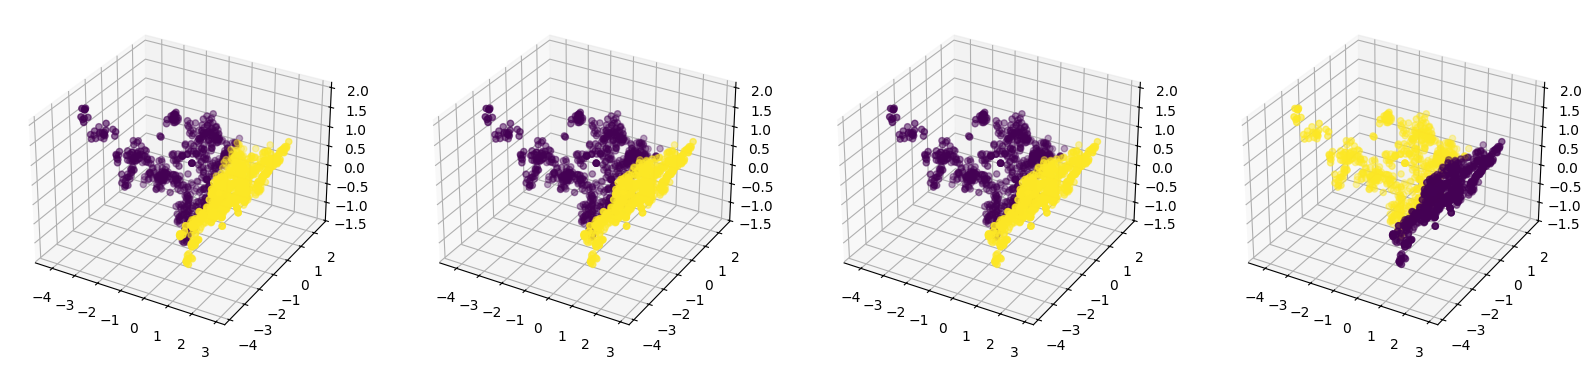

In [60]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1,4,1,projection='3d')
ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=kmeans_2.labels_)
ax = fig.add_subplot(1,4,2,projection='3d')
ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=kmeans_all.labels_)
ax = fig.add_subplot(1,4,3,projection='3d')
ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=kmeans.labels_)
ax = fig.add_subplot(1,4,4,projection='3d')
ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=kmeans_pp.labels_)
plt.show()

anche a dimensioni maggior i permane la situazione

In [61]:
print(f"mu_inf_sc per le 2 componenti principali: {normalized_mutual_info_score(kmeans_2.labels_, y_enc.flatten())}")
print(f"mu_inf_sc tutte le componenti: {normalized_mutual_info_score(kmeans_all.labels_, y_enc.flatten())}")
print(f"mu_inf_sc dati originali: {normalized_mutual_info_score(kmeans.labels_, y_enc.flatten())}")
print(f"mu_inf_sc kmeans++: {normalized_mutual_info_score(kmeans_pp.labels_, y_enc.flatten())}")

mu_inf_sc per le 2 componenti principali: 0.03379672325240217
mu_inf_sc tutte le componenti: 0.010642014990965471
mu_inf_sc dati originali: 0.010642014990965471
mu_inf_sc kmeans++: 0.010642014990965471


e la score conferma la scrsa qualità di questa clusterizzazione

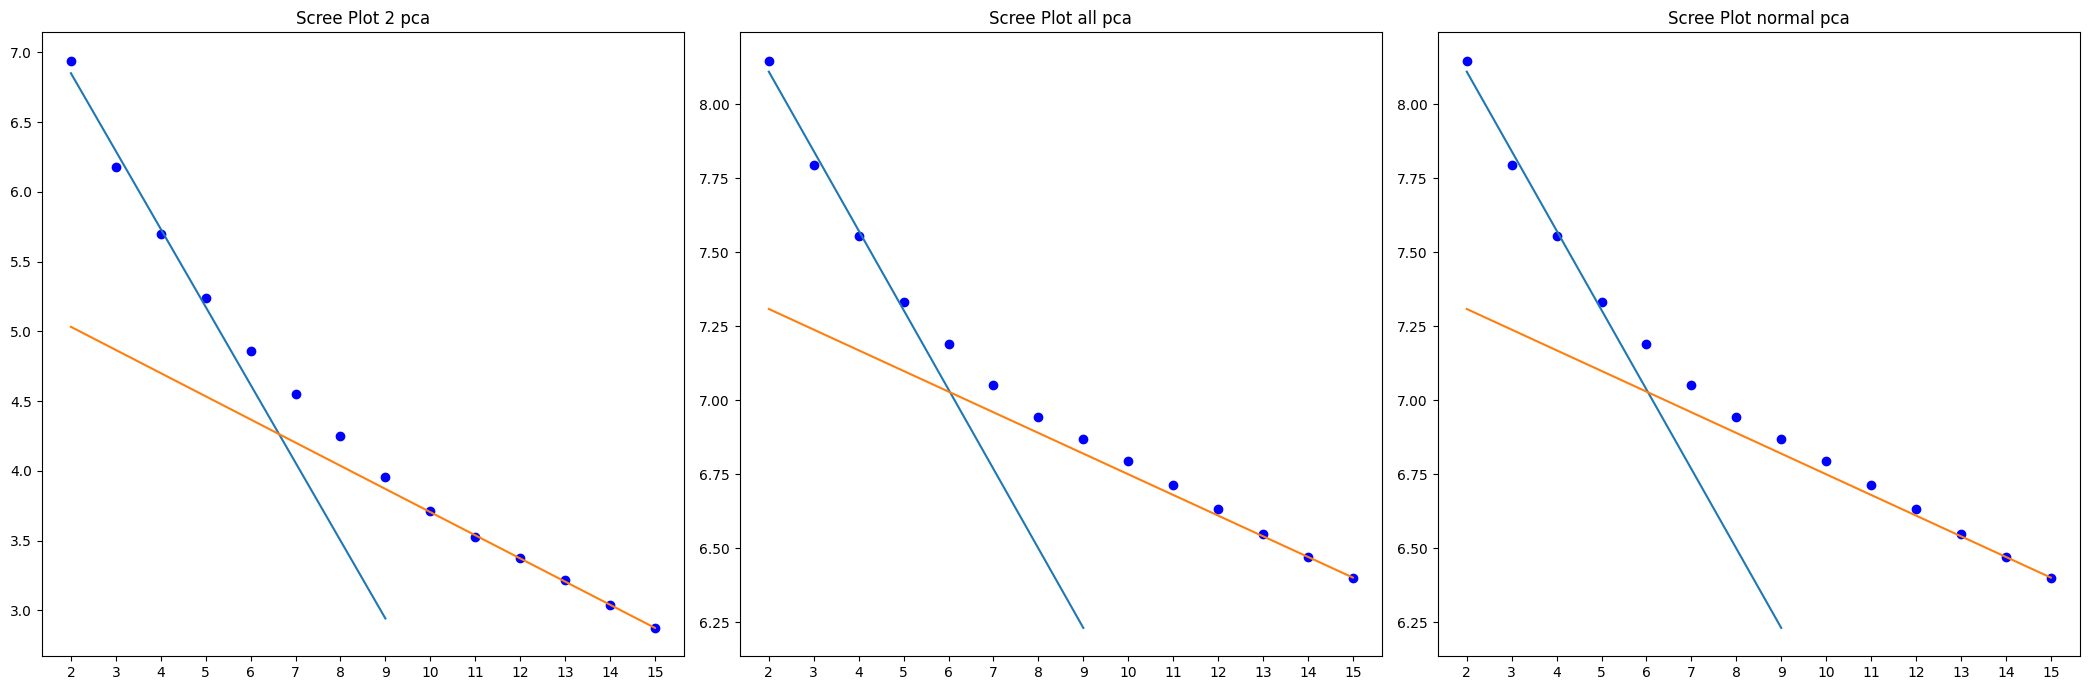

In [62]:
# Scree plot with linear regression lines for different segments to aid in determining the optimal number of clusters (k)

# Possible values for k in k-means
nk_base = np.arange(2, 16)

loss_2 = np.zeros(nk_base.shape[0])
for i, nk in enumerate(nk_base):
    kmeans = KMeans(n_clusters=nk, random_state=0, n_init=20).fit(projection[:,:1])
    loss_2[i] = kmeans.inertia_
reg_first_segment_2 = LinearRegression().fit(nk_base[:4].reshape(-1, 1), np.log(loss_2[:4]))
reg_last_segment_2 = LinearRegression().fit(nk_base[12:16].reshape(-1, 1), np.log(loss_2[12:16]))
predicted_first_segment_2 = reg_first_segment_2.predict(nk_base[:8].reshape(-1, 1))
predicted_last_segment_2 = reg_last_segment_2.predict(nk_base.reshape(-1, 1))

loss_all = cp.copy(loss_2)
for i, nk in enumerate(nk_base):
    kmeans = KMeans(n_clusters=nk, random_state=0, n_init=20).fit(projection)
    loss_all[i] = kmeans.inertia_
reg_first_segment_all = LinearRegression().fit(nk_base[:4].reshape(-1, 1), np.log(loss_all[:4]))
reg_last_segment_all = LinearRegression().fit(nk_base[12:16].reshape(-1, 1), np.log(loss_all[12:16]))
predicted_first_segment_all = reg_first_segment_all.predict(nk_base[:8].reshape(-1, 1))
predicted_last_segment_all = reg_last_segment_all.predict(nk_base.reshape(-1, 1))

loss = cp.copy(loss_2)
for i, nk in enumerate(nk_base):
    kmeans = KMeans(n_clusters=nk, random_state=0, n_init=20).fit(x_uns)
    loss[i] = kmeans.inertia_
reg_first_segment = LinearRegression().fit(nk_base[:4].reshape(-1, 1), np.log(loss[:4]))
reg_last_segment = LinearRegression().fit(nk_base[12:16].reshape(-1, 1), np.log(loss[12:16]))
predicted_first_segment = reg_first_segment.predict(nk_base[:8].reshape(-1, 1))
predicted_last_segment = reg_last_segment.predict(nk_base.reshape(-1, 1))

fig, ax = plt.subplots(1,3,figsize=(21, 7))
ax[0].scatter(nk_base, np.log(loss_2), c='b')
ax[0].set_xticks(nk_base)
ax[0].set_title('Scree Plot 2 pca')
ax[0].plot(nk_base[:8], predicted_first_segment_2[:8], label='Linear Regression (First Segment)')
ax[0].plot(nk_base, predicted_last_segment_2, label='Linear Regression (Last Segment)')

ax[1].scatter(nk_base, np.log(loss_all), c='b')
ax[1].set_xticks(nk_base)
ax[1].set_title('Scree Plot all pca')
ax[1].plot(nk_base[:8], predicted_first_segment_all[:8], label='Linear Regression (First Segment)')
ax[1].plot(nk_base, predicted_last_segment_all, label='Linear Regression (Last Segment)')

ax[2].scatter(nk_base, np.log(loss), c='b')
ax[2].set_xticks(nk_base)
ax[2].set_title('Scree Plot normal pca')
ax[2].plot(nk_base[:8], predicted_first_segment[:8], label='Linear Regression (First Segment)')
ax[2].plot(nk_base, predicted_last_segment, label='Linear Regression (Last Segment)')

plt.tight_layout()
# Display the plot
plt.show()


possiamo notare che con gli screeplot il miglior numero di cluster è 6/7

In [ ]:
perpl = {}
for x in np.linspace(100,105,6, endpoint=True):
        X_embedded = TSNE(n_components=3, learning_rate='auto', init='pca', perplexity=x).fit_transform(x_uns)
        dbscan = DBSCAN( eps=1, min_samples=2).fit(X_embedded)
        c_n ={i:(sum(dbscan.labels_ == i)) for i in np.unique(dbscan.labels_)}
        perpl[x] = (c_n[max(c_n, key=c_n.get)])

print(max(perpl, key=perpl.get))

(np.float64(102.0), 1)


facendo un po di validazione trovo che 102 è la perplexity mugliore per dbscan

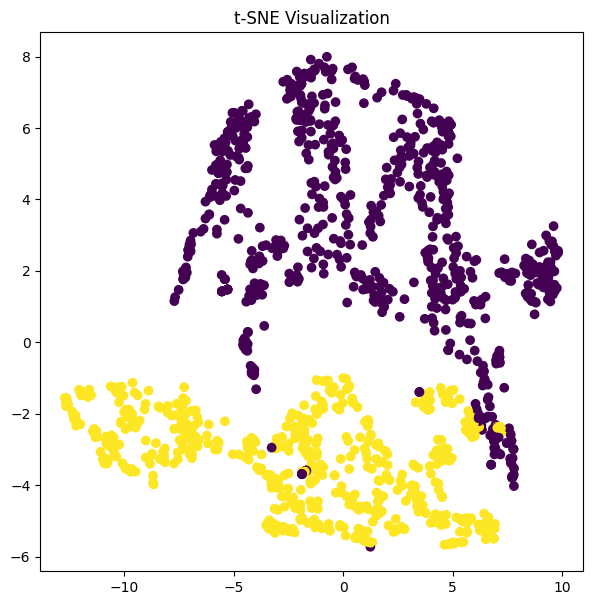

In [63]:
X_embedded = TSNE(n_components=3, learning_rate='auto', init='pca', perplexity=102).fit_transform(x_uns)
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_enc)
ax.set_title('t-SNE Visualization')
plt.show()

a primo impatto tsne sembra fare un buon lavoro

In [64]:
for eps in np.linspace(0.5,1.5,11, endpoint=True):
    dbscan = DBSCAN(eps, min_samples=2).fit(X_embedded)
    c_n ={i:sum(dbscan.labels_ == i) for i in np.unique(dbscan.labels_)}
    result = {key:value for key, value in c_n.items() if value >= 10}
    print(f"epsilon: {round(eps,1)}  dbscan_labels: {len(np.unique(dbscan.labels_))}  cluster importanti: {len(result)}   cluster maggioritario: {max(result, key=result.get)}  mu_inf_sc: {normalized_mutual_info_score(dbscan.labels_, y_enc.flatten())}")

epsilon: 0.5  dbscan_labels: 62  cluster importanti: 45   cluster maggioritario: 5  mu_inf_sc: 0.3098376874890225
epsilon: 0.6  dbscan_labels: 36  cluster importanti: 27   cluster maggioritario: 4  mu_inf_sc: 0.38029012954322083
epsilon: 0.7  dbscan_labels: 22  cluster importanti: 18   cluster maggioritario: 6  mu_inf_sc: 0.4622309375640896
epsilon: 0.8  dbscan_labels: 16  cluster importanti: 13   cluster maggioritario: 1  mu_inf_sc: 0.5800769731542592
epsilon: 0.9  dbscan_labels: 14  cluster importanti: 12   cluster maggioritario: 1  mu_inf_sc: 0.5859082040223315
epsilon: 1.0  dbscan_labels: 6  cluster importanti: 5   cluster maggioritario: 1  mu_inf_sc: 0.6296638822901438
epsilon: 1.1  dbscan_labels: 5  cluster importanti: 4   cluster maggioritario: 0  mu_inf_sc: 0.16117036876376975
epsilon: 1.2  dbscan_labels: 5  cluster importanti: 4   cluster maggioritario: 0  mu_inf_sc: 0.16117036876376975
epsilon: 1.3  dbscan_labels: 4  cluster importanti: 3   cluster maggioritario: 0  mu_inf_sc

andadno a validare epsilon trovo che la migliore è 1

In [65]:
dbscan_1 = DBSCAN(1, min_samples=2).fit(X_embedded)

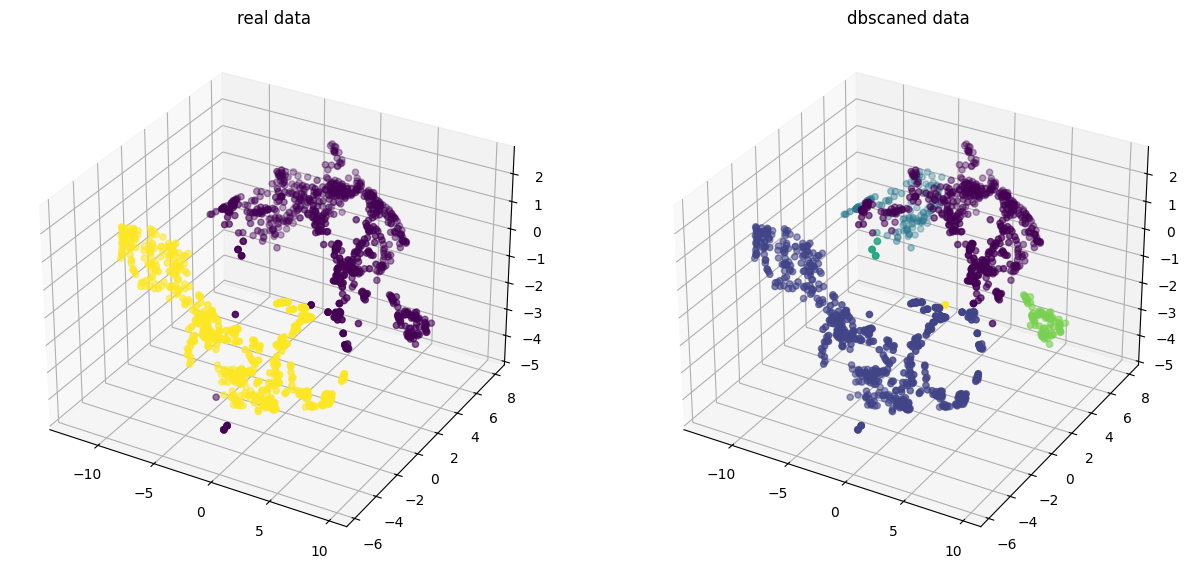

In [66]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1],X_embedded[:,2], c=y_enc)
ax.set_title('real data')
ax = fig.add_subplot(1,2,2,projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1],X_embedded[:,2], c=dbscan_1.labels_)
ax.set_title('dbscaned data')
plt.show()

dbscan fa una buona separazione nonostante usi molti piu cluster

### 3. Supervised Learning

Generate a subset of the data of 372 elements that would be saved as test set. With the rest of the data generate the following models: Logistic Regression, Decision tree (use the ID3 algorithm), Naive Bayesian and k-NN. 

Investigate the effect of regularization (when possible) and use cross validation for setting the hyper-parameters when needed. 

Compare the performances in terms of accuracy, precision, recall and F1-score on the test set. Comment these results at the light of those obtained from the Unsupervised Learning analysis. Could you propose a way to improve these results?     


In [81]:
data_te = data.iloc[:372,:]
data_tr = data.iloc[372:,:]
print(type(data_te))

Xtr = data_tr.iloc[:,:4]
scaler = preprocessing.StandardScaler().fit(Xtr)
Xtr = scaler.transform(Xtr)

Ytr = data_tr.iloc[:,4]
Ytr = Ytr.values
Ytr = Ytr.reshape(1,-1)
Ytr = Ytr[0]

Xte = data_te.iloc[:,:4]
scaler = preprocessing.StandardScaler().fit(Xte)
Xte = scaler.transform(Xte)

Yte = data_te.iloc[:,4]
Yte = Yte.values
Yte = Yte.reshape(1,-1)
Yte = Yte[0]

<class 'pandas.core.frame.DataFrame'>


accuracy = 203-207  precision avg 237-241  recall avg 257-261

## Logistic Regression

In [78]:
def sigmoidM(x, w):
    y = 1/(1+np.exp(-np.matmul(x,w)))
    return y

def RidgeLogLoss(x, y, w, lam):
    n = np.shape(x)[0]
    return -(1/n)*np.sum(y*np.log(sigmoidM(x,w)) + (1-y)*np.log(1-sigmoidM(x,w))) + lam*LA.norm(w,2)

def RidgeGradient(w, lam):
    return 2*lam*w

def lassoGradient(w, lam):
    g = np.ones(w.shape)
    g[w < 0.] = -1.0
    return lam*g

def lassoLogLoss(x,y,w,lam):
    n = np.shape(x)[0]
    return -(1/n)*np.sum(y*np.log(sigmoidM(x,w)) + (1-y)*np.log(1-sigmoidM(x,w))) + lam*LA.norm(w,1)

def logistic(x, y, iter, gamma, lam, lamr):
    d = np.shape(x)
    loss = np.zeros(iter)
    np.random.seed(33)
    w =  np.random.uniform(0, 0.01, d[1])
    W = np.zeros((d[1], iter))
    for i in range(iter):
        W[:,i] = w
        w = w - (gamma) * ((2/d[0])*(np.transpose(x) @ (sigmoidM(x,w)-y)) + lamr * lassoGradient(w,lam) + (1-lamr) * RidgeGradient(w,lam))
        loss[i] = -(1/d[0])*np.sum(y*np.log(sigmoidM(x,w)) + (1-y)*np.log(1-sigmoidM(x,w))) + (1-lamr)* lam*LA.norm(w,2) + lamr*lam*LA.norm(w,2)

    return W,loss

def get_y_pred(X_train,y_train,X_test,iter,gamma,lam,lamr,soglia):
    W, loss = logistic(X_train,y_train,iter,gamma,lam,lamr)
    w = W[:,iter-1]
    y_pred = sigmoidM(X_test, w)
    y_pred[y_pred < soglia] = 0.
    y_pred[y_pred >= soglia] = 1.
    return y_pred, loss, w

def print_res(y_true,y_pred,w,loss):
    target_names = ['0', '1']
    print(classification_report(y_true, y_pred, target_names=target_names))
    plt.plot(loss)
    plt.xlabel("Iterazioni")
    plt.ylabel("Loss Value")
    plt.title("Grafico Della Loss")
    plt.show()

def con_matr(y_true,y_pred):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

In [79]:
ite = 10000
gamma = 0.01
lam = 1

*base*

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       213
           1       0.93      1.00      0.96       159

    accuracy                           0.97       372
   macro avg       0.96      0.97      0.97       372
weighted avg       0.97      0.97      0.97       372



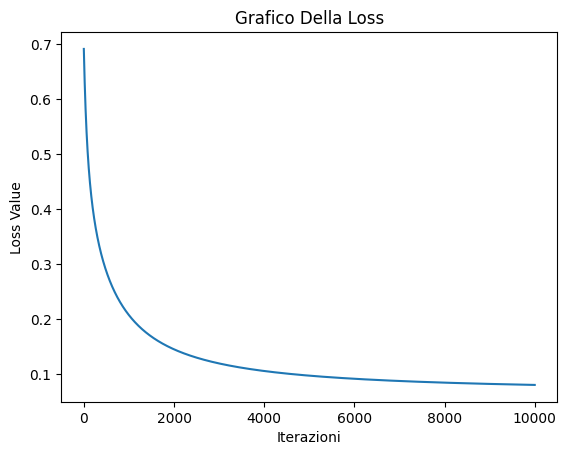

In [82]:
y_pred, loss, w = get_y_pred(Xtr,Ytr,Xte,ite,gamma,0,0,0.5)
print_res(Yte,y_pred,w,loss)

*ridge*

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       213
           1       0.81      0.88      0.84       159

    accuracy                           0.86       372
   macro avg       0.86      0.86      0.86       372
weighted avg       0.86      0.86      0.86       372



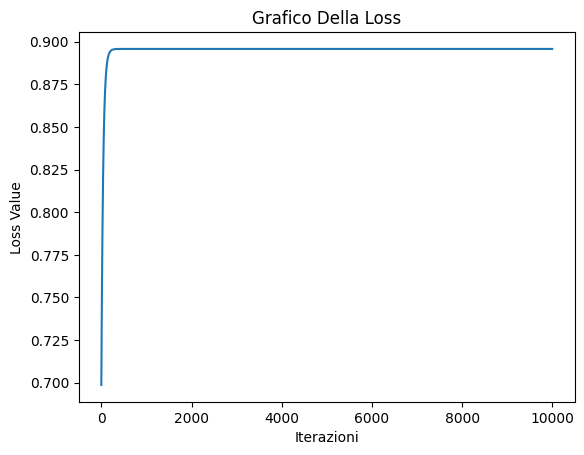

In [71]:
y_pred, loss, w = get_y_pred(Xtr,Ytr,Xte,ite,gamma,lam,0,0.5)
print_res(Yte,y_pred,w,loss)

*lasso*

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       213
           1       0.69      0.81      0.74       159

    accuracy                           0.76       372
   macro avg       0.76      0.77      0.76       372
weighted avg       0.77      0.76      0.76       372



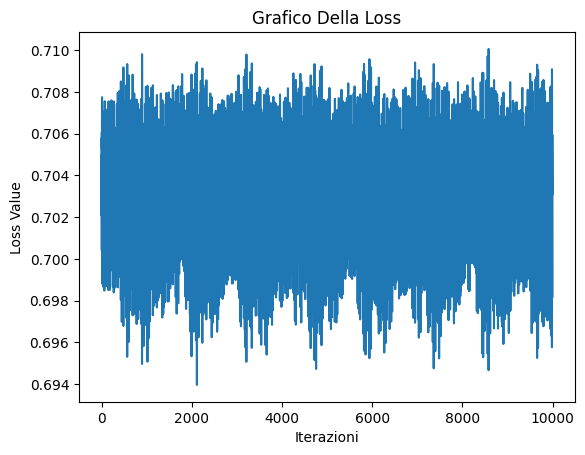

In [72]:
y_pred, loss, w = get_y_pred(Xtr,Ytr,Xte,ite,gamma,lam,1,0.5)
print_res(Yte,y_pred,w,loss)

In [76]:
k_groups = np.array_split(data,10)
partials = []
y_partials = []
partial_datas = []
for g_te in k_groups:
    Xtr_m = np.concatenate([group for i, group in enumerate(k_groups) if group != g_te])[:,:4]
    scaler = preprocessing.StandardScaler().fit(Xtr_m)
    Xtr_m = scaler.transform(Xtr_m)
    Ytr_m = np.concatenate([group for i, group in enumerate(k_groups) if group != g_te])[:,4]
    Ytr_m = Ytr_m.values
    Ytr_m = Ytr_m.reshape(1,-1)
    Ytr_m = Ytr_m[0]
    Xte_m = g_te[:,:4]
    scaler = preprocessing.StandardScaler().fit(Xte_m)
    Xte_m = scaler.transform(Xte_m)
    Yte_m = g_te[:,4]
    Yte_m = Yte_m.values
    Yte_m = Yte_m.reshape(1,-1)
    Yte_m = Yte_m[0]
    

C:\Users\pitom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

*elnet*

In [75]:
from sklearn.metrics import classification_report
data_np = data.to_numpy()
class_reports = []
y_preds = []
lamr_values = []
datas = []
for lamr in np.linspace(0,1,10, endpoint= True):
    k_groups = np.array_split(data,10)
    partials = []
    y_partials = []
    partial_datas = []
    for g_te in k_groups: 

        Xtr_m = np.concatenate([group for i, group in enumerate(k_groups) if group != g_te])[:,:4]
        scaler = preprocessing.StandardScaler().fit(Xtr_m)
        Xtr_m = scaler.transform(Xtr_m)
        Ytr_m = np.concatenate([group for i, group in enumerate(k_groups) if group != g_te])[:,4]
        Ytr_m = Ytr_m.values
        Ytr_m = Ytr_m.reshape(1,-1)
        Ytr_m = Ytr_m[0]
        Xte_m = g_te[:,:4]
        scaler = preprocessing.StandardScaler().fit(Xte_m)
        Xte_m = scaler.transform(Xte_m)
        Yte_m = g_te[:,4]
        Yte_m = Yte_m.values
        Yte_m = Yte_m.reshape(1,-1)
        Yte_m = Yte_m[0]

        y_pred, _, _ = get_y_pred(Xtr_m,Ytr_m,Xte_m,ite,gamma,lam,lamr,0.5)
        target_names = ['0', '1']
        report = classification_report(y_pred, y_pred, target_names=target_names, output_dict=True)
        partials.append(report)  
        y_partials.append(y_pred)
        partial_datas.append(i_g)
    best_partial_index = max(range(len(partials)), key=lambda i: partials[i]["accuracy"])
    class_reports.append(partials[best_partial_index])
    y_preds.append(y_partials[best_partial_index])
    datas.append(partial_datas[best_partial_index])
    lamr_values.append(lamr)
  
best_index = max(range(len(class_reports)), key=lambda i: class_reports[i]["accuracy"])
best_y_pred = y_preds[best_index]
best_lamr = lamr_values[best_index]
best_datas = datas[best_index]
print(best_lamr)
print(classification_report(best_y_pred, best_y_pred, target_names=target_names))


C:\Users\pitom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\pitom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\pitom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C

0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       199
           1       1.00      1.00      1.00       173

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



In [ ]:
y_pred, loss, w = get_y_pred(,Ytr,Xte,ite,gamma,lam,1,0.5)
print_res(Yte,y_pred,w,loss)

## Decision Tree

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       213
           1       0.98      0.99      0.98       159

    accuracy                           0.99       372
   macro avg       0.99      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



<function matplotlib.pyplot.show(close=None, block=None)>

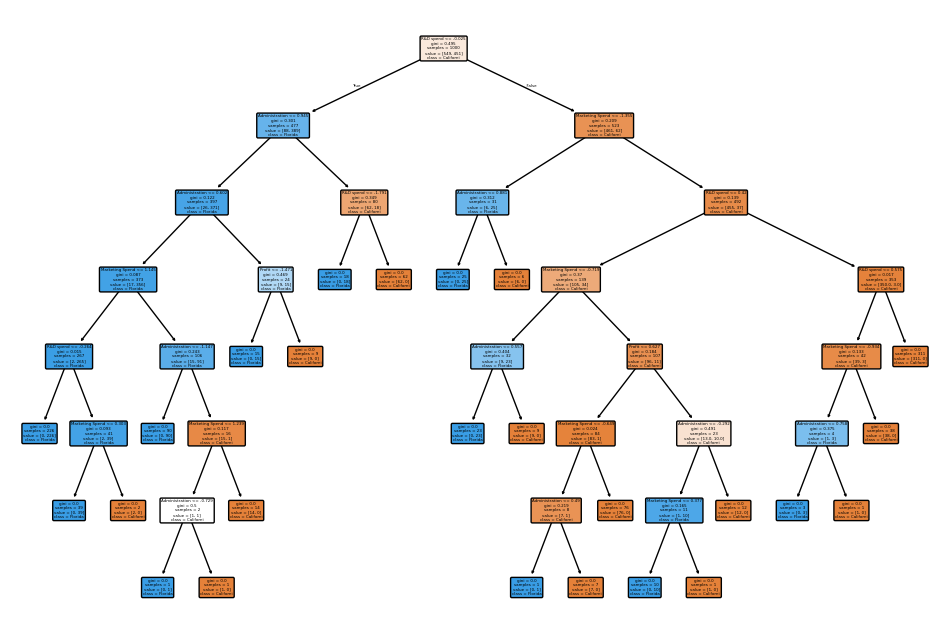

In [37]:
albero = tree.DecisionTreeClassifier()
albero.fit(Xtr,Ytr)
y_pred = albero.predict(Xte)
print(classification_report(Yte, y_pred, target_names=["0","1"]))
plt.figure(figsize=(12,8))
df = pd.DataFrame(X)
plot_tree(albero, filled=True,feature_names=["R&D spend","Administration","Marketing Spend","Profit"],class_names=["Californi","Florida"], rounded=True)
plt.show


## Naive bayes

In [38]:
gnbC = GaussianNB(var_smoothing=1e-16)
gnbC.fit(Xtr,Ytr)
y_pred = gnbC.predict(Xte)
print(classification_report(Yte, y_pred, target_names=["0","1"]))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       213
           1       0.82      0.83      0.82       159

    accuracy                           0.85       372
   macro avg       0.85      0.85      0.85       372
weighted avg       0.85      0.85      0.85       372



In [39]:
gnbC = BernoulliNB()
gnbC.fit(Xtr,Ytr)
y_pred = gnbC.predict(Xte)
print(classification_report(Yte, y_pred, target_names=["0","1"]))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85       213
           1       0.76      0.92      0.84       159

    accuracy                           0.84       372
   macro avg       0.85      0.85      0.84       372
weighted avg       0.86      0.84      0.84       372



In [40]:
def distance(point_one, point_two, dist, p):
    if dist == 'euclidean':
        return euclidean(point_one, point_two)
    else:
        return minkowski(point_one, point_two, p=p)


def get_neighbors(train_set, test_point, label_col, n_neighbors, dist, p):
    # Calculate distances between the test point and all points in the training set
    dist = np.array([distance(train_point, test_point, dist, p) for train_point in train_set])
    # Get indices that would sort the distances in ascending order
    idx_dist = dist.argsort()
    # Order the training set and labels based on the sorted distances
    ordered_train = train_set[idx_dist, :]
    ordered_label = label_col[idx_dist]
    # Return the top n_neighbors neighbors and their labels
    return ordered_train[:n_neighbors], ordered_label[:n_neighbors]

def predict(train_set, test_point, labels, n_neighbors, dist, p):
    # Get the nearest neighbors and their labels
    neigh, neigh_label = get_neighbors(train_set, test_point, labels, n_neighbors, dist, p)
    # Count occurrences of each label among the neighbors
    values, counts = np.unique(neigh_label, return_counts=True)
    # Find the label with the highest count (majority class)
    idx = np.argmax(counts)
    # Return the predicted label
    return values[idx]

def evaluate(train_set, test_set, label, n_neighbors, dist='Euclidean', p=2):
    # Initialize counters for correct and incorrect predictions
    correct_predict = 0
    wrong_predict = 0
    result = []
    # Extract labels and features from the training and test sets
    
    train_labels = train_set[label].values
    train_set = train_set.drop(label, axis=1)
    
    test_labels = test_set[label].values
    test_set = test_set.drop(label, axis=1)
    # Iterate through each row in the test dataset
    for index in tqdm(range(len(test_set.index))):
        # Predict the class label for the current test row
        result.append(predict(train_set.values, test_set.iloc[index].values, train_labels, n_neighbors, dist, p))
        # Check if the predicted value matches the actual value
        if result[index] == test_labels[index]:
            # Increase the correct prediction count
            correct_predict += 1
        else:
            # Increase the incorrect prediction count
            wrong_predict += 1

    # Calculate and return the accuracy
    print(classification_report(Yte, result, target_names=["0","1"]))

In [44]:
evaluate(data_tr, data_te, 'class', n_neighbors=5, dist='minkowski', p = 2)

100%|██████████| 372/372 [00:01<00:00, 233.17it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       159

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372

